# Unsupervised

### Preprocess the dataset for clustering

In [1]:
import pandas as pd

df = pd.read_csv('temp/olist_orders_dataset_df.csv')


In [2]:
df.shape

(102280, 19)

Create a balanced dataset.

In [3]:
from sklearn.utils import resample, shuffle

df_True = df[df.anomaly]
df_False = df[df.anomaly==False]

df_False = resample(df_False, replace=True, n_samples=df_True.shape[0])

df_balanced = shuffle(pd.concat([df_True, df_False]))
df_balanced.reset_index(drop=True, inplace=True)
X_balanced = df_balanced.drop(['anomaly'], axis=1)
y_balanced = df_balanced['anomaly']

Using only selected features

In [4]:
X = df.drop(['anomaly'], axis=1)
y = df['anomaly']


In [5]:
X_balanced = pd.DataFrame(X_balanced)
X = pd.DataFrame(X)

Transform the features to follow a normal distribution

In [6]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_balanced = pd.DataFrame(qt.fit_transform(X_balanced), columns=X_balanced.columns)
X = pd.DataFrame(qt.fit_transform(X), columns=X.columns)

### Create a Table of performance

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

table_of_performance = pd.DataFrame(columns=['algorithm', 'confusion matrix', 'accuracy', 'precision', 'recall', 'rand index', 'mutual information based score', 'homogeneity', 'completeness', 'v-measure'])

def add_performance(algorithm, y, y_predict):
    global table_of_performance

    cm = confusion_matrix(y, y_predict)
    accuracy = accuracy_score(y, y_predict)
    precision = precision_score(y, y_predict)
    recall = recall_score(y, y_predict)
    rand_index = rand_score(y, y_predict)
    mutual_info_score = adjusted_mutual_info_score(y, y_predict)
    homogeneity = homogeneity_score(y, y_predict)
    completeness = completeness_score(y, y_predict)
    v_measure = v_measure_score(y, y_predict)

    new_row = {'algorithm': algorithm, 'confusion matrix': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'rand index': rand_index, 'mutual information based score': mutual_info_score, 'homogeneity': homogeneity, 'completeness': completeness, 'v-measure': v_measure}

    table_of_performance.loc[len(table_of_performance)] = new_row

### Visualization of clustering after PCA

unbalanced

<Axes: xlabel='x', ylabel='y'>

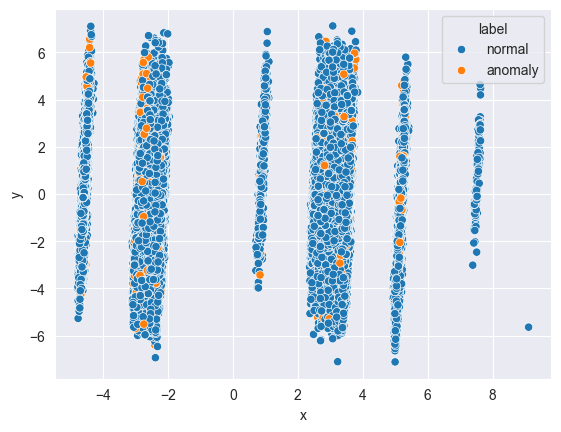

In [8]:
from sklearn.decomposition import  PCA

pca = PCA(n_components=2)
pct = pca.fit_transform(X)

colors = ['anomaly' if elem else 'normal' for elem in y]

data = pd.concat([pd.DataFrame(pct), pd.DataFrame(colors)], axis=1)

data.columns = ['x', 'y', 'label']

import seaborn as sns

sns.scatterplot(data=data, x="x", y="y", hue="label")


balanced

<Axes: xlabel='x', ylabel='y'>

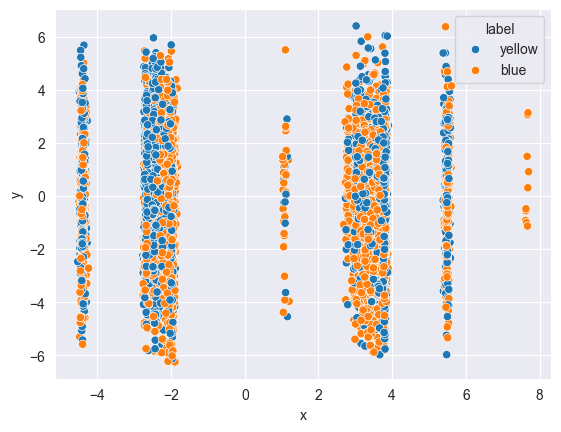

In [9]:

from sklearn.decomposition import  PCA

pca_balanced = PCA(n_components=2)
pct_balanced = pca_balanced.fit_transform(X_balanced)

colors_balanced = ['yellow' if elem else 'blue' for elem in y_balanced]

data_balanced = pd.concat([pd.DataFrame(pct_balanced), pd.DataFrame(colors_balanced)], axis=1)

data_balanced.columns = ['x', 'y', 'label']

sns.scatterplot(data=data_balanced, x="x", y="y", hue="label")


### KMeans

#### Unbalanced KMeans

In [25]:
from sklearn.cluster import KMeans
'''
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
'''

'\nfrom yellowbrick.cluster import KElbowVisualizer\n\n# Instantiate the clustering model and visualizer\nmodel = KMeans()\nvisualizer = KElbowVisualizer(model, k=(2, 12))\n\nvisualizer.fit(X)        # Fit the data to the visualizer\nvisualizer.show()        # Finalize and render the figure\n'

The optimal number of clusters is 5.

In [26]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=0)
k_means.fit(X)

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

from sklearn.metrics.pairwise import pairwise_distances_argmin_min

k_means_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, k_means_cluster_centers)).T
k_means_distances_df.columns = ['cluster', 'distance']

k_means_distances_df = pd.concat([k_means_distances_df, y], axis=1)
k_means_distances_df.groupby(['cluster', 'anomaly']).count()


distance
cluster anomaly          
0.0     False       44247
        True         1982
1.0     False       52529
        True         3522

In [27]:
y_predict = k_means_distances_df['cluster'].map({0: False, 1: True})
add_performance('KMeans', y, y_predict)


#### Balanced KMeans

In [28]:
from sklearn.cluster import KMeans
'''
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_balanced = KMeans()
visualizer_balanced = KElbowVisualizer(model_balanced, k=(2, 12))

visualizer_balanced.fit(X_balanced)        # Fit the data to the visualizer
visualizer_balanced.show()        # Finalize and render the figure
'''

'\nfrom yellowbrick.cluster import KElbowVisualizer\n\n# Instantiate the clustering model and visualizer\nmodel_balanced = KMeans()\nvisualizer_balanced = KElbowVisualizer(model_balanced, k=(2, 12))\n\nvisualizer_balanced.fit(X_balanced)        # Fit the data to the visualizer\nvisualizer_balanced.show()        # Finalize and render the figure\n'

In [29]:
k_means_balanced = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=0)
k_means_balanced.fit(X_balanced)

k_means_cluster_centers_balanced = k_means_balanced.cluster_centers_

k_means_labels_balanced = pairwise_distances_argmin(X_balanced, k_means_cluster_centers_balanced)

k_means_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, k_means_cluster_centers_balanced)).T
k_means_distances_df_balanced.columns = ['cluster', 'distance']
k_means_distances_df_balanced = pd.concat([k_means_distances_df_balanced, y_balanced], axis=1)
k_means_distances_df_balanced.groupby(['cluster', 'anomaly']).count()


distance
cluster anomaly          
0.0     False        2505
        True         1982
1.0     False        2999
        True         3522

In [30]:
y_predict_balanced = k_means_distances_df_balanced['cluster'].map({0: False, 1: True})
add_performance('KMeans balanced', y_balanced, y_predict_balanced)


In [31]:
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall,rand index,mutual information based score,homogeneity,completeness,v-measure
0,KMeans,"[[44247, 52529], [1982, 3522]]",0.467041,0.062836,0.639898,0.502168,0.002184,0.004703,0.001432,0.002195
1,KMeans balanced,"[[2505, 2999], [1982, 3522]]",0.547511,0.540101,0.639898,0.504470,0.006774,0.006755,0.006927,0.006840


### Affinity Propagation

#### Unbalanced

Trying the algorithm on unbalanced dataset is computationally impossible and meaningless.

In [32]:
'''
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
len(cluster_centers_indices)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\naf = AffinityPropagation(random_state=0).fit(X)\ncluster_centers_indices = af.cluster_centers_indices_\nlabels = af.labels_\nlen(cluster_centers_indices)\n'

#### Balanced

In [33]:
'''
from sklearn.cluster import AffinityPropagation

pca = PCA(n_components=5)
pct_balanced = pca.fit_transform(X_balanced)
af_balanced = AffinityPropagation(random_state=0).fit(pct_balanced)
cluster_centers_indices_balanced = af_balanced.cluster_centers_indices_
labels_balanced = af_balanced.labels_
len(cluster_centers_indices_balanced)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\npca = PCA(n_components=5)\npct_balanced = pca.fit_transform(X_balanced)\naf_balanced = AffinityPropagation(random_state=0).fit(pct_balanced)\ncluster_centers_indices_balanced = af_balanced.cluster_centers_indices_\nlabels_balanced = af_balanced.labels_\nlen(cluster_centers_indices_balanced)\n'

### Mean shift

#### Unbalanced

In [34]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth = estimate_bandwidth(X, quantile=0.3)\n\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True)\nms.fit(X)\nlabels = ms.labels_\ncluster_centers = ms.cluster_centers_\n'

In [35]:
'''
mean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T
mean_shift_distances_df.columns = ['cluster', 'distance']
mean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())
'''

"\nmean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T\nmean_shift_distances_df.columns = ['cluster', 'distance']\nmean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())\n"

#### Balanced

In [36]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth_balanced = estimate_bandwidth(X_balanced, quantile=0.3)

ms_balanced = MeanShift(bandwidth=bandwidth_balanced, bin_seeding=True)
ms_balanced.fit(X_balanced)
labels_balanced = ms_balanced.labels_
cluster_centers_balanced = ms_balanced.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth_balanced = estimate_bandwidth(X_balanced, quantile=0.3)\n\nms_balanced = MeanShift(bandwidth=bandwidth_balanced, bin_seeding=True)\nms_balanced.fit(X_balanced)\nlabels_balanced = ms_balanced.labels_\ncluster_centers_balanced = ms_balanced.cluster_centers_\n'

In [37]:
'''
mean_shift_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, cluster_centers_balanced)).T
mean_shift_distances_df_balanced.columns = ['cluster', 'distance']
mean_shift_distances_df_balanced = pd.concat([mean_shift_distances_df_balanced, y_balanced], axis=1)
print(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).mean())
print(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).count())
'''

"\nmean_shift_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, cluster_centers_balanced)).T\nmean_shift_distances_df_balanced.columns = ['cluster', 'distance']\nmean_shift_distances_df_balanced = pd.concat([mean_shift_distances_df_balanced, y_balanced], axis=1)\nprint(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).mean())\nprint(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).count())\n"

### Hierarchical clustering

#### Unbalanced

In [38]:
'''
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters=2).fit(X)
'''

'\nfrom sklearn.cluster import AgglomerativeClustering\n\nhierarchical_clustering = AgglomerativeClustering(n_clusters=2).fit(X)\n'

In [39]:
'''
hierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])
hierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)
pd.DataFrame(hierarchical_clustering_labels_df.value_counts())
'''

"\nhierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])\nhierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)\npd.DataFrame(hierarchical_clustering_labels_df.value_counts())\n"

#### Balanced

In [40]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering_balanced = AgglomerativeClustering(n_clusters=2).fit(X_balanced)

In [41]:
hierarchical_clustering_labels_df_balanced = pd.DataFrame(hierarchical_clustering_balanced.labels_, columns=['cluster'])
hierarchical_clustering_labels_df_balanced = pd.concat([hierarchical_clustering_labels_df_balanced, y_balanced], axis=1)
hierarchical_clustering_labels_df_balanced.value_counts()


cluster  anomaly
0        True       3632
         False      3190
1        False      2314
         True       1872
Name: count, dtype: int64

In [42]:
y_predict_balanced = hierarchical_clustering_labels_df_balanced['cluster'].map({0: True, 1: False})
add_performance('hierarchical clustering balanced', y_balanced, y_predict_balanced)


In [43]:
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall,rand index,mutual information based score,homogeneity,completeness,v-measure
0,KMeans,"[[44247, 52529], [1982, 3522]]",0.467041,0.062836,0.639898,0.502168,0.002184,0.004703,0.001432,0.002195
1,KMeans balanced,"[[2505, 2999], [1982, 3522]]",0.547511,0.540101,0.639898,0.504470,0.006774,0.006755,0.006927,0.006840
2,hierarchical clustering balanced,"[[2314, 3190], [1872, 3632]]",0.540153,0.532395,0.659884,0.503179,0.004981,0.004942,0.005157,0.005047


### HDBSCAN

#### Unbalanced

In [44]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)

HDBSCAN(min_cluster_size=20)

In [45]:
hdbscan_labels_df = pd.DataFrame(hdb.labels_, columns=['clusters'])
hdbscan_labels_df = pd.concat([hdbscan_labels_df, y], axis=1)

y_predict = hdbscan_labels_df['clusters'].map(lambda x: x < 0)
add_performance('HDBSCAN', y, y_predict)

#### Balanced

In [46]:
from sklearn.cluster import HDBSCAN

hdb_balanced = HDBSCAN(min_cluster_size=20)
hdb_balanced.fit(X_balanced)

HDBSCAN(min_cluster_size=20)

In [47]:
hdbscan_labels_df_balanced = pd.DataFrame(hdb_balanced.labels_, columns=['clusters'])
hdbscan_labels_df_balanced = pd.concat([hdbscan_labels_df_balanced, y_balanced], axis=1)

y_predict_balanced = hdbscan_labels_df_balanced['clusters'].map(lambda x: x < 0)
add_performance('HDBSCAN balanced', y_balanced, y_predict_balanced)

### OPTICS

#### Unbalanced

In [48]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2).fit(X)


/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [49]:
optics_labels_df = pd.DataFrame(optics.labels_, columns=['clusters'])
optics_labels_df = pd.concat([optics_labels_df, y], axis=1)

y_predict = optics_labels_df['clusters'].map(lambda x: x < 0)
add_performance('OPTICS', y, y_predict)


#### Balanced

In [50]:
from sklearn.cluster import OPTICS

optics_balanced = OPTICS(min_samples=2).fit(X_balanced)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [51]:
optics_labels_df_balanced = pd.DataFrame(optics_balanced.labels_, columns=['clusters'])
optics_labels_df_balanced = pd.concat([optics_labels_df_balanced, y_balanced], axis=1)

y_predict_balanced = optics_labels_df_balanced['clusters'].map(lambda x: x < 0)
add_performance('OPTICS balanced', y_balanced, y_predict_balanced)

### BIRCH

#### Unbalanced

In [52]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=2)
brc.fit(X)
brc.predict(X)


array([0, 0, 0, ..., 0, 0, 0])

In [53]:
brc_labels_df = pd.DataFrame(brc.labels_, columns=['clusters'])
brc_labels_df = pd.concat([brc_labels_df, y], axis=1)
brc_labels_df.value_counts()


clusters  anomaly
0         False      58949
1         False      37827
0         True        3754
1         True        1750
Name: count, dtype: int64

In [54]:
y_predict = brc_labels_df['clusters'].map({0: True, 1: False})
add_performance('BIRCH', y, y_predict)


In [55]:
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall,rand index,mutual information based score,homogeneity,completeness,v-measure
0,KMeans,"[[44247, 52529], [1982, 3522]]",0.467041,0.062836,0.639898,0.502168,0.002184,0.004703,0.001432,0.002195
1,KMeans balanced,"[[2505, 2999], [1982, 3522]]",0.547511,0.540101,0.639898,0.504470,0.006774,0.006755,0.006927,0.006840
2,hierarchical clustering balanced,"[[2314, 3190], [1872, 3632]]",0.540153,0.532395,0.659884,0.503179,0.004981,0.004942,0.005157,0.005047
3,HDBSCAN,"[[76221, 20555], [4639, 865]]",0.753676,0.040383,0.157158,0.628700,0.001372,0.002389,0.000976,0.001385
4,HDBSCAN balanced,"[[3809, 1695], [4317, 1187]]",0.453852,0.411867,0.215661,0.504214,0.008654,0.007981,0.009622,0.008725
5,OPTICS,"[[54700, 42076], [3025, 2479]]",0.559044,0.055639,0.450400,0.506968,0.000045,0.000120,0.000037,0.000056
6,OPTICS balanced,"[[2569, 2935], [2987, 2517]]",0.462028,0.461665,0.457304,0.502839,0.004100,0.004165,0.004165,0.004165
7,BIRCH,"[[37827, 58949], [1750, 3754]]",0.406541,0.059870,0.682049,0.517465,0.001323,0.002790,0.000876,0.001334


#### Balanced

In [56]:
from sklearn.cluster import Birch

brc_balanced = Birch(n_clusters=2)
brc_balanced.fit(X_balanced)
brc_balanced.predict(X_balanced)


array([0, 0, 1, ..., 0, 1, 1])

In [57]:
brc_labels_df_balanced = pd.DataFrame(brc_balanced.labels_, columns=['clusters'])
brc_labels_df_balanced = pd.concat([brc_labels_df_balanced, y_balanced], axis=1)
brc_labels_df_balanced.value_counts()


clusters  anomaly
0         True       3731
          False      3297
1         False      2207
          True       1773
Name: count, dtype: int64

In [58]:
y_predict_balanced = brc_labels_df_balanced['clusters'].map({0: True, 1: False})
add_performance('BIRCH balanced', y_balanced, y_predict_balanced)


In [59]:
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall,rand index,mutual information based score,homogeneity,completeness,v-measure
0,KMeans,"[[44247, 52529], [1982, 3522]]",0.467041,0.062836,0.639898,0.502168,0.002184,0.004703,0.001432,0.002195
1,KMeans balanced,"[[2505, 2999], [1982, 3522]]",0.547511,0.540101,0.639898,0.504470,0.006774,0.006755,0.006927,0.006840
2,hierarchical clustering balanced,"[[2314, 3190], [1872, 3632]]",0.540153,0.532395,0.659884,0.503179,0.004981,0.004942,0.005157,0.005047
3,HDBSCAN,"[[76221, 20555], [4639, 865]]",0.753676,0.040383,0.157158,0.628700,0.001372,0.002389,0.000976,0.001385
4,HDBSCAN balanced,"[[3809, 1695], [4317, 1187]]",0.453852,0.411867,0.215661,0.504214,0.008654,0.007981,0.009622,0.008725
5,OPTICS,"[[54700, 42076], [3025, 2479]]",0.559044,0.055639,0.450400,0.506968,0.000045,0.000120,0.000037,0.000056
6,OPTICS balanced,"[[2569, 2935], [2987, 2517]]",0.462028,0.461665,0.457304,0.502839,0.004100,0.004165,0.004165,0.004165
7,BIRCH,"[[37827, 58949], [1750, 3754]]",0.406541,0.059870,0.682049,0.517465,0.001323,0.002790,0.000876,0.001334
8,BIRCH balanced,"[[2207, 3297], [1773, 3731]]",0.539426,0.530876,0.677871,0.503064,0.004938,0.004865,0.005154,0.005005


### Spectral clustering

#### balanced

In [60]:
'''
from sklearn.cluster import SpectralClustering
import joblib

spectral_clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_balanced)
'''

"\nfrom sklearn.cluster import SpectralClustering\nimport joblib\n\nspectral_clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_balanced)\n"

In [61]:
'''
joblib.dump(spectral_clustering, 'temp/olist_orders_dataset_spectral_clustering_model.pkl')
loaded_model = joblib.load('temp/olist_orders_dataset_spectral_clustering_model.pkl')
'''

"\njoblib.dump(spectral_clustering, 'temp/olist_orders_dataset_spectral_clustering_model.pkl')\nloaded_model = joblib.load('temp/olist_orders_dataset_spectral_clustering_model.pkl')\n"

### Performance

In [62]:
table_of_performance.to_csv('temp/olist_orders_dataset_unsupervised_performance.csv', index=False)